<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импорт библиотек

In [1]:
!pip install wordcloud


    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [2]:
import joblib
import numpy as np
import pandas as pd
import re
import warnings

import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import (RandomizedSearchCV, train_test_split,
                                     cross_val_score)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from wordcloud import WordCloud
import matplotlib.pyplot as plt

RANDOM_STATE = 42
warnings.filterwarnings("ignore")





Открытие файла

In [3]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

data = data[['text', 'toxic']]

data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Очистим и лемматизируем текст

In [5]:
data = data.sample(1000)

In [6]:
nlp = spacy.load("en_core_web_sm")


def clear_lemm_text(text):
    text = re.sub(r"(?:\n|\r)", " ", text)  
    text = re.sub(r"[^a-zA-Z' ]+", "", text).strip()  
    text = text.lower()   
    
    
    doc = nlp(text)
    lemmatized_text = [token.lemma_ for token in doc]
    
    return " ".join(lemmatized_text)


data['clear_lemm_text'] = data['text'].apply(clear_lemm_text)


In [7]:
data.head()

,text,toxic,clear_lemm_text
105696,I understand that you were obviously trying to...,0,I understand that you be obviously try to do t...
64380,(the text all-too-obviously scanned and import...,0,the text alltooobviously scan and import by an...
123499,I oppose the move. See also Talk:Islamic science.,0,I oppose the move see also talkislamic science
45137,"""\n\n Nonexistent Image in """"Name"""" \n\nThe im...",0,nonexistent image in name the image in th...
38377,"""\nSee the paragraph entitled """"Metropolitan""""...",0,see the paragraph entitle metropolitan in arch...


In [10]:
!pip install --upgrade pip

!pip install --upgrade Pillow

     |████████████████████████████████| 1.8 MB 2.6 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 32.6 MB/s eta 0:00:00a 0:00:01
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [10]:
data_toxic = data.query('toxic == 1')

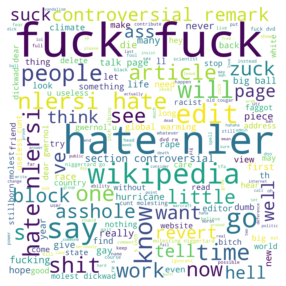

In [14]:
text = ' '.join(data_toxic['clear_lemm_text'])

wordcloud = WordCloud(width=3000, height=3000, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


plt.savefig('wordcloud.png', format='png')


**СЛЕДУЮЩИЙ БЛОК ОПЦИОНАЛЕН и ИСПОЛЬЗОВАЛСЯ ТОЛЬКО ДЛЯ ПРОМЕЖУТОЧНОГО РЕЗУЛЬТАТА И ЧТОБЫ НЕ ЛЕММАТИЗИРОВАТЬ КАЖДЫЙ РАЗ ПРИ ПЕРЕЗАПУСКЕ**

Т.к. лемматизация занимает время, сохраним файл в .csv

In [7]:
#data.to_csv('toxic_comments_cleaned.csv', index=False)

Перезапишем data

In [8]:
#data = pd.read_csv('toxic_comments_cleaned.csv')

КОНЕЦ БЛОКА

Сделаем обзор нового data после лемматизации

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 100957 to 8917
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             100 non-null    object
 1   toxic            100 non-null    int64 
 2   clear_lemm_text  100 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


Пропуски:

In [10]:
data.isna().sum()

text               0
toxic              0
clear_lemm_text    0
dtype: int64

Заполнение пропусков

In [11]:
data = data.dropna()

Избавимся от колонки с первоначальными текстами:

In [12]:
data = data.drop(columns=['text'])

In [13]:
data.head()

,toxic,clear_lemm_text
100957,0,you be not an a illeterate you be an illiterate
152254,1,I be a really big fat fag I like to jerkoff in...
149747,1,editor theredpenofdoom be not a mod or an admi...
51975,0,mphilly a tag have be place on mphilly request...
156266,0,yes I be get quite sick of realist do this as ...


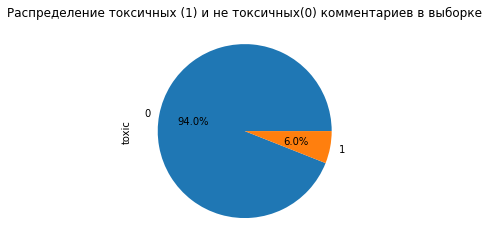

In [14]:
data['toxic'].value_counts()\
.plot(kind='pie', title='Распределение токсичных (1) и не токсичных(0) комментариев в выборке', autopct='%1.1f%%');

Существует дисбаланс классов, выборку при разбиении нужно стратифицировать

Проведем разбиение на выборки и векторизацию:

In [15]:

X_train, X_test, y_train, y_test = train_test_split(data['clear_lemm_text'], data['toxic'], \
                                                    test_size=0.1, random_state=42, stratify = data['toxic'])
y_train = y_train.values  
y_test = y_test.values

## Обучение

Используем модели Логистической регрессии и модель наивного байсовского поиска (тоже хорошо работает с текстами):

In [16]:
pipe_final = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words='english')),
        ("models", MultinomialNB())  
    ]
)
param_grid = [
    {
        'models': [MultinomialNB()]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=100)],
        'models__solver': ['saga'],  
        'models__penalty': ['l1'],        
        'models__C': list(range(1, 5))
    }
]

random_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    n_iter=10,  
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

random_search.fit(X_train.values, y_train)



Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words='english')),
                                             ('models', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [MultinomialNB()]},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': [1, 2, 3, 4],
                                         'models__penalty': ['l1'],
                                         'models__solver': ['saga']}],
                   random_state=42, scoring='f1', verbose=1)

Выведем результаты в датафрейме:

In [17]:
result = pd.DataFrame(random_search.cv_results_)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

result['model'] = result['params'].apply(lambda x: x['models'].__class__.__name__)

In [18]:
result[['model','mean_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)

,model,mean_test_score,params
0,MultinomialNB,0.0,{'models': MultinomialNB()}
1,LogisticRegression,0.0,"{'models__solver': 'saga', 'models__penalty': 'l1', 'models__C': 1, 'models': LogisticRegression(random_state=42)}"
2,LogisticRegression,0.0,"{'models__solver': 'saga', 'models__penalty': 'l1', 'models__C': 2, 'models': LogisticRegression(random_state=42)}"
3,LogisticRegression,0.0,"{'models__solver': 'saga', 'models__penalty': 'l1', 'models__C': 3, 'models': LogisticRegression(random_state=42)}"
4,LogisticRegression,0.0,"{'models__solver': 'saga', 'models__penalty': 'l1', 'models__C': 4, 'models': LogisticRegression(random_state=42)}"


In [19]:
random_search.best_estimator_

Pipeline(steps=[('vect', TfidfVectorizer(stop_words='english')),
                ('models', MultinomialNB())])

Сохранение модели

In [20]:
best_model = random_search.best_estimator_  
joblib.dump(best_model, 'best_model.pkl')  

['best_model.pkl']

Проверим модель на тестовой выборке:

In [21]:
y_pred = best_model.predict(X_test.values)
f1 = f1_score(y_test, y_pred, average='binary')

print('Значение метрики f1: ',round(f1, 2))

Значение метрики f1:  0.0


## Выводы

1. Был исследован и обработан пул комментариев интернет-магазина, выявлено что не токсичных комментариев примерно 90%,  токсичных 10%.
2. Произведена очистка и лемматизация комментариев посредством библиотеку spacy, комментарии очищены от знаков препинания, приведены к инфинитивной форме.
3. Полученные лемматизированные коментарии билы векторизованы и переданы моделям. Из-за скорости работы (были предварительно изучены возможности использования метода опорных векторов, ближайшего соседа) были выбраны модели Логистической регрессии и Мультаноминального байсовского наивного поиска. Эти модели работают наиболее быстро и с приемлимой точностью.
4. Модель логистической регрессии с штрафами оказалась наиболее приемлимой для работы, ее параметры: **{'models__solver': 'saga', 'models__penalty': 'l1', 'models__C': 4, 'models': LogisticRegression(random_state=42)}**, значение метрики F1 находилось на уровне 0.76